# Flux Partitioning with uncertainty prediction

This notebook aims at providing an uncertainty estimation for the flux partitioning problem, using Bayesian Neural Networks.
Thanks to Mohamed Aziz Bhouri for his help with Bayesian modeling and the HMC fine-tuning, and to Weiwei Zhan for her flux partitioning NN model and her data.

## Initialization and pre-training

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tqdm import tqdm

from HMC import HMC
from flux_preprocessing import load_dataset
from flux_utils import get_layer_model, fluxes_SIF_predict_noSIF, count_out_distribution
from flux_viz import quad_viz, dual_viz_val

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams["legend.frameon"] = False
plt.rcParams['savefig.dpi'] = 310
plt.rcParams['font.size'] = 13
data_dir = Path("../data")

tf.random.set_seed(0)

hidden_dim = 32

Let's first preprocess the data set. This notebook currently uses simulated data with added noise.

In [2]:
train, test, val, EV1_train1, EV2_train1, NEE_train1, label_train, EV1_test1, EV2_test1, NEE_test1, label_test, EV1_val1, EV2_val1, NEE_val1, label_val, NEE_max_abs = load_dataset(
    'NNinput_SCOPE_US_Ha1_1314.csv')
label_train_night = tf.boolean_mask(label_train, label_train == 0)
EV1_train1_night = tf.boolean_mask(EV1_train1, label_train == 0)
EV2_train1_night = tf.boolean_mask(EV2_train1, label_train == 0)
NEE_train1_night = tf.boolean_mask(NEE_train1, label_train == 0)

These are both the training and testing sets. A 70-30 split is done chronologically, to avoid both our sets to be highly correlated.

Let's now define an NN model to predict both Gross Primary Product (GPP) and Respiration (Reco) from the NEE observations. This model has 2 branches, one for each flux, which are then combined to predict the NEE.

In [3]:
def NN_noSIF(n_neuron, activation1, activation2):
    # GPP
    APAR_input = Input(shape=(1,), dtype='float32', name='APAR_input')
    EV_input1 = Input(shape=(EV1_train1.shape[1],), dtype='float32', name='EV_input1')
    x = Dense(n_neuron, activation=activation1, name='hidden1_1')(EV_input1)
    ln_GPP = Dense(1, activation=None, name='ln_GPP')(x)
    GPP_1 = Lambda(lambda x: K.exp(x), name='GPP_1')(ln_GPP)
    GPP = keras.layers.Multiply(name='GPP')([GPP_1, APAR_input])

    # Reco
    EV_input2 = Input(shape=(EV2_train1.shape[1],), dtype='float32', name='EV_input2')
    x = Dense(n_neuron, activation=activation1, name='hidden2_1')(EV_input2)
    x = Dense(n_neuron, activation=activation2, name='hidden2_2')(x)
    ln_Reco = Dense(1, activation=None, name='ln_Reco')(x)
    Reco = Lambda(lambda x: K.exp(x), name='Reco')(ln_Reco)

    NEE = keras.layers.Subtract(name='NEE')([Reco, GPP])

    model_NEE = Model(inputs=[APAR_input, EV_input1, EV_input2], outputs=[NEE])
    model_NEE.compile(
        optimizer=keras.optimizers.Adam(5e-3),
        loss=keras.losses.MeanSquaredError() # Use NEE percentage?
    )

    return model_NEE

The training is relatively fast (a few seconds on my setup). We can check that the model is able to predict NEE correctly.

In [4]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
model1 = NN_noSIF(n_neuron=hidden_dim, activation1='relu', activation2='relu')
model1.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             NEE_train1,
                             epochs=500,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)

pred_train = model1({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1})

train_loss = model1.loss(pred_train, NEE_train1)
pred_test = model1({'APAR_input': label_test, 'EV_input1': EV1_test1, 'EV_input2': EV2_test1})
test_loss = model1.loss(pred_test, NEE_test1)

print("Model initial training loss = {train_loss:.3e} and testing loss = {test_loss:.3e}".format(train_loss = train_loss, test_loss=test_loss))

Model initial training loss = 1.743e-03 and testing loss = 2.244e-03


Here is a brief overview of the model that we are using. Depending on the specifications provided in the above function, the number  of trainable parameters is in the $10^3:10^4$ range.

In [5]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EV_input2 (InputLayer)         [(None, 4)]          0           []                               
                                                                                                  
 EV_input1 (InputLayer)         [(None, 6)]          0           []                               
                                                                                                  
 hidden2_1 (Dense)              (None, 32)           160         ['EV_input2[0][0]']              
                                                                                                  
 hidden1_1 (Dense)              (None, 32)           224         ['EV_input1[0][0]']              
                                                                                              

## HMC run

Then, we proceed to the HMC random walk to sample values for the parameters. Here are a few observations worth noticing that I realized during my fine-tuning:

- Compared to the NODE-HMC framework, `epsilon` has to be increased significantly to enable a proper search ($\sim \times 10$);
- When the number of parameters of the model increases, `epsilon` has to be slightly reduced to avoid numerical instabilities, but more importantly `L` has to be significantly increased ($\sim\times 10$). Otherwise, the HMC would be unable to conduct a proper exploration for $\log(\lambda)$;
- When these conditions are met, HMC exploration is surprisingly fast  (> 10 samples/sec), with a high acceptance rate, and usually passes the diagnostics;

In [6]:
burn_in = int(1e4)
n_iter = int(1e5)

n_obs_train = NEE_train1.shape[0]
n_obs_test = NEE_test1.shape[0]
n_obs_val = NEE_val1.shape[0]

p_glob = []
acceptance_glob = []
L = 10
eps = 5e-4
fig_dir = Path("../etc") / ("lnGPP_APARlabel_L_{L}_eps_{eps:1.0e}_niter_{n:1.0e}".format(L=L, eps=eps, n=n_iter))
fig_dir.mkdir(exist_ok=True)
diagnostic_dir = Path("../etc/diagnostic") / fig_dir.name
diagnostic_dir.mkdir(exist_ok=True)
keras.utils.plot_model(model1, to_file=fig_dir / "model.png")

def sample(model, inputs):
    # Create HMC super-model
    n_obs = inputs[1].shape[0]
    hmc = HMC(model, L=L, epsilon_min=eps, epsilon_max=eps, batch_size=n_obs, n_obs=n_obs)

    # Initialize bookkeeping
    parameters = []  # bookkeeping the parameters
    log_gamma = []  # bookkeeping the loggamma
    log_lambda = []  # bookkeeping the loggamma
    log_likelihood = []  # bookkeeping the loggamma
    acceptance = []

    # training loop
    hmc.init_parameters(inputs)
    for step in tqdm(range(n_iter + burn_in)):
        new_state, loss, p, accepted = hmc(inputs, tf.constant(step, dtype=tf.float32),
                                              tf.constant(n_iter, dtype=tf.float32))

        p_glob.append(p)
        acceptance_glob.append(accepted)

        # bookkeeping
        if step >= burn_in:
            parameters.append(new_state.position)
            log_gamma.append(new_state.log_gamma)
            log_lambda.append(new_state.log_lambda)
            log_likelihood.append(loss)
            acceptance.append(accepted)

    parameters = tf.stack(parameters, axis=0).numpy()
    log_gamma = tf.concat(log_gamma, axis=0).numpy()
    log_lambda = tf.concat(log_lambda, axis=0).numpy()
    log_likelihood = tf.concat(log_likelihood, axis=0).numpy()
    acceptance = np.array(acceptance)
    print("Sampling done: {n_iter} steps with accepting rate {acceptance:.2f}".format(n_iter=n_iter, acceptance=np.mean(acceptance)))
    return hmc, parameters, log_gamma, log_lambda, log_likelihood, acceptance

100%|██████████| 110000/110000 [12:11<00:00, 150.47it/s]


Sampling done: 100000 steps with accepting rate 0.96


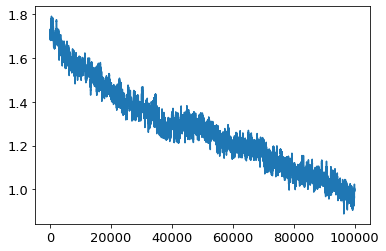

In [7]:
hmc, parameters, log_gamma, log_lambda, log_likelihood, acceptance = sample(model1, (
    {'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1}, NEE_train1))
plt.plot(log_lambda)

Now that the random walk is done, let's check on the MAP estimate, and compare the results with the recorded loss.

In [8]:
# Computing MAP estimate
idx_MAP = np.argmax(log_likelihood)
MAP = tf.constant(parameters[idx_MAP, :], dtype=tf.float32)
hmc.set_model_params(MAP)
NEE_train_MAP, GPP_train_MAP, Reco_train_MAP = fluxes_SIF_predict_noSIF(hmc.model, label_train, EV1_train1, EV2_train1,
                                                                        NEE_max_abs)
NEE_test_MAP, GPP_test_MAP, Reco_test_MAP = fluxes_SIF_predict_noSIF(hmc.model, label_test, EV1_test1, EV2_test1,
                                                                     NEE_max_abs)
NEE_val_MAP, GPP_val_MAP, Reco_val_MAP = fluxes_SIF_predict_noSIF(hmc.model, label_val, EV1_val1, EV2_val1,
                                                                     NEE_max_abs)

train_pred = hmc.model({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1})
train_loss = hmc.model.loss(train_pred, NEE_train1)

test_pred = hmc.model({'APAR_input': label_test, 'EV_input1': EV1_test1, 'EV_input2': EV2_test1})
test_loss = hmc.model.loss(test_pred, NEE_test1)
print("MAP training loss = {train_loss:.3e} and testing loss = {test_loss:.3e}".format(train_loss = train_loss, test_loss=test_loss))
print(np.max(log_likelihood))

MAP training loss = 1.026e-02 and testing loss = 1.900e-02
14109.173


In [9]:
state = hmc.state(0,0,0)
w = state.position
loss = hmc.get_loss(({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1}, NEE_train1))
print(tf.exp(state.log_gamma) * (loss / 2.0 + 1.0))
print(tf.exp(state.log_lambda) * (tf.reduce_sum(tf.abs(w)) + 1.0))
print(-(tf.cast(n_obs_train, tf.float32) / 2.0 + 1.0) * state.log_gamma)
print(-(tf.cast(hmc.param_num, tf.float32) + 1.0) * state.log_lambda)
-hmc.potential_energy(loss, state)

tf.Tensor([1868.164], shape=(1,), dtype=float32)
tf.Tensor([714.9799], shape=(1,), dtype=float32)
tf.Tensor([-14855.712], shape=(1,), dtype=float32)
tf.Tensor([-1502.3413], shape=(1,), dtype=float32)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([13774.91], dtype=float32)>

In [10]:
model1.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             NEE_train1,
                             epochs=500,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)
pred_train = model1({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1})

train_loss = model1.loss(pred_train, NEE_train1)
pred_test = model1({'APAR_input': label_test, 'EV_input1': EV1_test1, 'EV_input2': EV2_test1})
test_loss = model1.loss(pred_test, NEE_test1)

print("Model initial training loss = {train_loss:.3e} and testing loss = {test_loss:.3e}".format(train_loss = train_loss, test_loss=test_loss))
state = hmc.state(0,0,0)
w = state.position
loss = hmc.get_loss(({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1}, NEE_train1))
print(tf.exp(state.log_gamma) * (loss / 2.0 + 1.0))
print(tf.exp(state.log_lambda) * (tf.reduce_sum(tf.abs(w)) + 1.0))
print(-(tf.cast(n_obs_train, tf.float32) / 2.0 + 1.0) * state.log_gamma)
print(-(tf.cast(hmc.param_num, tf.float32) + 1.0) * state.log_lambda)
-hmc.potential_energy(loss, state)

Model initial training loss = 1.632e-03 and testing loss = 2.061e-03
tf.Tensor([1860.1492], shape=(1,), dtype=float32)
tf.Tensor([840.55115], shape=(1,), dtype=float32)
tf.Tensor([-14855.712], shape=(1,), dtype=float32)
tf.Tensor([-1502.3413], shape=(1,), dtype=float32)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([13657.354], dtype=float32)>

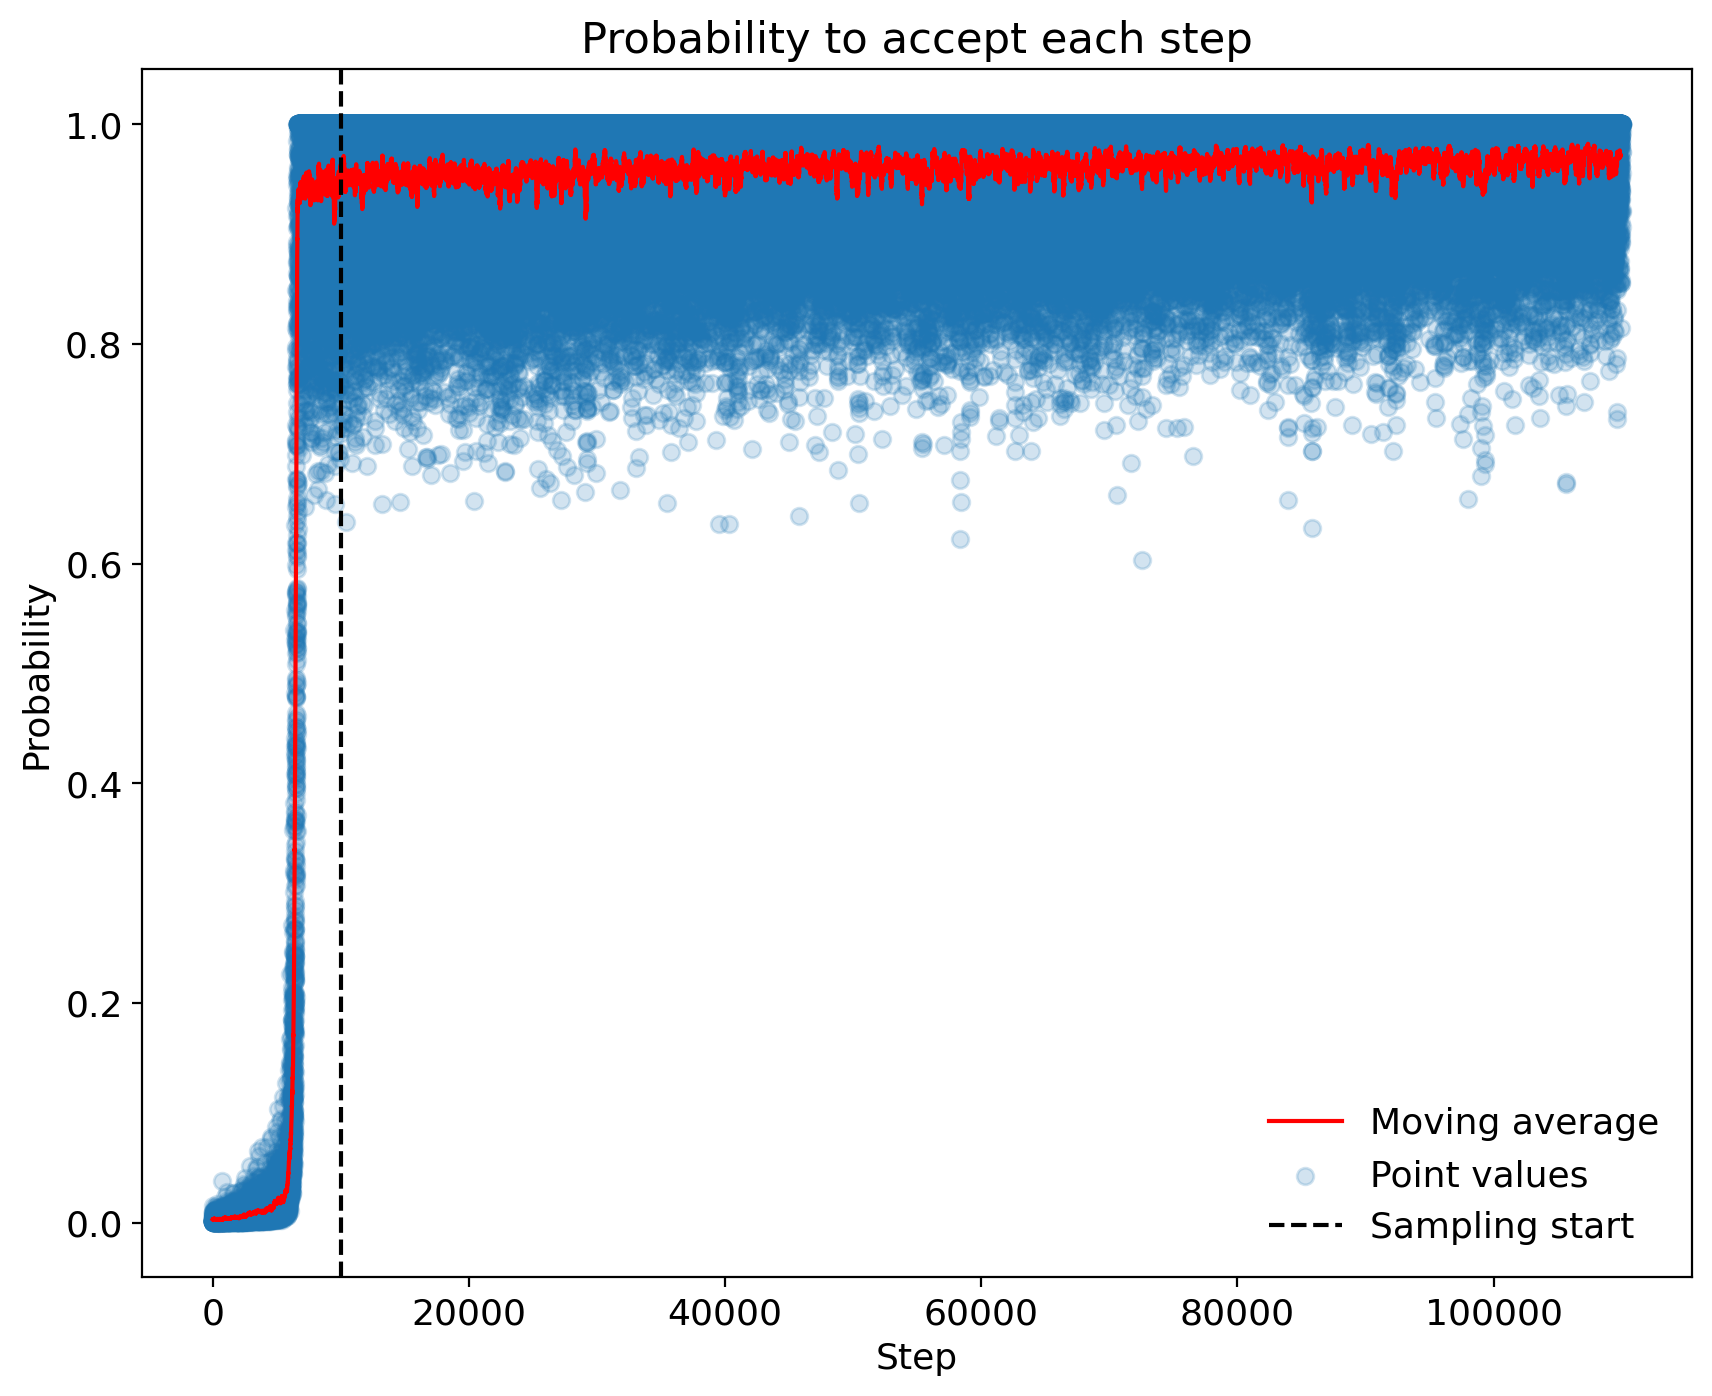

In [11]:
fig, axs = plt.subplots(1,1, figsize=(10,8), dpi=200)
n = 100
prob = p_glob[:(burn_in + n_iter)]
moving_avg = np.convolve(np.array(list(t.numpy() for t in prob)).ravel(), np.ones((n,))/n, mode="valid")
axs.plot(range(len(moving_avg)), moving_avg, "r-", label="Moving average")
axs.scatter(range(len(prob)), prob, alpha=0.2, label="Point values")
axs.axvline(x=burn_in, color="black", linestyle="--", label="Sampling start")
axs.legend(loc="lower right")
axs.set_title("Probability to accept each step")
axs.set_xlabel("Step")
axs.set_ylabel("Probability")

# axs[1].plot(range(len(acceptance_glob)), np.cumsum(acceptance_glob)/np.arange(1, len(acceptance_glob)+1))
# axs[1].set_title("Evolution of acceptance ratio")
# axs[1].set_xlabel("Step")
# axs[1].set_ylabel("Acceptance ratio")

plt.savefig(fig_dir / "proba.png")
plt.show()

The MAP estimate is slightly worse than the pre-trained model.

## HMC sampling

Now that we have our random walk, let's sample from it and compute the mean and deviation of our predictions.

In [12]:
# preparing sampling
precision = np.exp(log_gamma)
n_samples = 1000
NEE_train_traj, GPP_train_traj, Reco_train_traj = np.zeros((n_obs_train, n_samples)), np.zeros(
    (n_obs_train, n_samples)), np.zeros(
    (n_obs_train, n_samples))
NEE_test_traj, GPP_test_traj, Reco_test_traj = np.zeros((n_obs_test, n_samples)), np.zeros(
    (n_obs_test, n_samples)), np.zeros(
    (n_obs_test, n_samples))
NEE_val_traj, GPP_val_traj, Reco_val_traj = np.zeros((n_obs_val, n_samples)), np.zeros(
    (n_obs_val, n_samples)), np.zeros(
    (n_obs_val, n_samples))
sigma_NEE = np.std(train["NEE_canopy"])
sigma_GPP = np.std(train["GPP_canopy"])
sigma_Reco = np.std(train["Reco_canopy"])

# sampling
model_NEE = get_layer_model(hmc.model, "NEE")
model_GPP = get_layer_model(hmc.model, "GPP")
model_Reco = get_layer_model(hmc.model, "Reco")
for k in tqdm(range(n_samples)):
    idx_1 = np.random.randint(0, n_iter - 1)
    idx_2 = np.random.randint(0, n_iter - 1)
    w_sample = parameters[-idx_1, :]
    precision_here = precision[-idx_1]
    hmc.set_model_params(w_sample)

    # Train sample
    NEE_train_traj[:, k] = NEE_max_abs * tf.squeeze(model_NEE({'APAR_input': label_train,
                                                               'EV_input1': EV1_train1,
                                                               'EV_input2': EV2_train1})) + sigma_NEE * np.random.normal() / np.sqrt(
        precision_here)
    GPP_train_traj[:, k] = NEE_max_abs * tf.squeeze(model_GPP({'APAR_input': label_train,
                                                               'EV_input1': EV1_train1,
                                                               'EV_input2': EV2_train1})) + sigma_GPP * np.random.normal() / np.sqrt(
        precision_here)
    Reco_train_traj[:, k] = NEE_max_abs * tf.squeeze(model_Reco({'APAR_input': label_train,
                                                                 'EV_input1': EV1_train1,
                                                                 'EV_input2': EV2_train1})) + sigma_Reco * np.random.normal() / np.sqrt(
        precision_here)

    # Test sample
    NEE_test_traj[:, k] = NEE_max_abs * tf.squeeze(model_NEE({'APAR_input': label_test,
                                                              'EV_input1': EV1_test1,
                                                              'EV_input2': EV2_test1})) + sigma_NEE * np.random.normal() / np.sqrt(
        precision_here)
    GPP_test_traj[:, k] = NEE_max_abs * tf.squeeze(model_GPP({'APAR_input': label_test,
                                                              'EV_input1': EV1_test1,
                                                              'EV_input2': EV2_test1})) + sigma_GPP * np.random.normal() / np.sqrt(
        precision_here)
    Reco_test_traj[:, k] = NEE_max_abs * tf.squeeze(model_Reco({'APAR_input': label_test,
                                                                'EV_input1': EV1_test1,
                                                                'EV_input2': EV2_test1})) + sigma_Reco * np.random.normal() / np.sqrt(
        precision_here)

    # Val sample
    NEE_val_traj[:, k] = NEE_max_abs * tf.squeeze(model_NEE({'APAR_input': label_val,
                                                              'EV_input1': EV1_val1,
                                                              'EV_input2': EV2_val1})) + sigma_NEE * np.random.normal() / np.sqrt(
        precision_here)
    GPP_val_traj[:, k] = NEE_max_abs * tf.squeeze(model_GPP({'APAR_input': label_val,
                                                              'EV_input1': EV1_val1,
                                                              'EV_input2': EV2_val1})) + sigma_GPP * np.random.normal() / np.sqrt(
        precision_here)
    Reco_val_traj[:, k] = NEE_max_abs * tf.squeeze(model_Reco({'APAR_input': label_val,
                                                                'EV_input1': EV1_val1,
                                                                'EV_input2': EV2_val1})) + sigma_Reco * np.random.normal() / np.sqrt(
        precision_here)

mu_NEE_pred_train = np.mean(NEE_train_traj, axis=1)
mu_GPP_pred_train = np.mean(GPP_train_traj, axis=1)
mu_Reco_pred_train = np.mean(Reco_train_traj, axis=1)
sigma_NEE_pred_train = np.std(NEE_train_traj, axis=1)
sigma_GPP_pred_train = np.std(GPP_train_traj, axis=1)
sigma_Reco_pred_train = np.std(Reco_train_traj, axis=1)

mu_NEE_pred_test = np.mean(NEE_test_traj, axis=1)
mu_GPP_pred_test = np.mean(GPP_test_traj, axis=1)
mu_Reco_pred_test = np.mean(Reco_test_traj, axis=1)
sigma_NEE_pred_test = np.std(NEE_test_traj, axis=1)
sigma_GPP_pred_test = np.std(GPP_test_traj, axis=1)
sigma_Reco_pred_test = np.std(Reco_test_traj, axis=1)

mu_NEE_pred_val = np.mean(NEE_val_traj, axis=1)
mu_GPP_pred_val = np.mean(GPP_val_traj, axis=1)
mu_Reco_pred_val = np.mean(Reco_val_traj, axis=1)
sigma_NEE_pred_val = np.std(NEE_val_traj, axis=1)
sigma_GPP_pred_val = np.std(GPP_val_traj, axis=1)
sigma_Reco_pred_val = np.std(Reco_val_traj, axis=1)

100%|██████████| 1000/1000 [00:17<00:00, 55.73it/s]


## Diagnostics

I run some diagnostics here (mostly auto-correlation). A more complete set of diagnostics is conducted in the corresponding R notebook.
The first step is to conduct a second HMC walk, with a different initialization, to check on the convergence.

In [13]:
# Diagnostic and logs
# dir = Path("../etc/diagnostic/flux_nn")
# dir.mkdir(exist_ok=True)
#
# model2 = NN_noSIF(n_neuron=hidden_dim, activation1='relu', activation2='relu')
# model2.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
#                              {'NEE': NEE_train1},
#                              epochs=500,
#                              batch_size=64,
#                              callbacks=[earlyStopping],
#                              validation_split=0.3,
#                              verbose=0)
# _, parameters2, log_gamma2, log_lambda2, log_likelihood2, acceptance2 = sample(model2, (
#     {'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1}, NEE_train1))

  7%|▋         | 8049/110000 [03:05<39:08, 43.40it/s]


KeyboardInterrupt: 

Both our runs are then saved to be processed in the R notebook (4 random parameters are sampled out of the thousands that are used).

In [ ]:
# np.save(diagnostic_dir / "log_gamma.npy", np.stack([log_gamma, log_gamma2], axis=1).astype(np.float64))
# np.save(diagnostic_dir / "log_lambda.npy", np.stack([log_lambda, log_lambda2], axis=1).astype(np.float64))
# np.save(diagnostic_dir / "log_likelihood.npy", np.stack([log_likelihood, log_likelihood2], axis=1).astype(np.float64))
# tmp = np.stack([parameters, parameters2], axis=2).astype(np.float64)
# for i in range(4):
#     random_param = np.random.randint(0, parameters.shape[1])
#     np.save(diagnostic_dir / ("parameter" + str(i) + ".npy"), tmp[:,random_param,:])
# np.save(diagnostic_dir / "full_parameters.npy", tmp)

Let's then check with 16 random parameters that the auto-correlation plot doesn't show any symptomatic behavior.

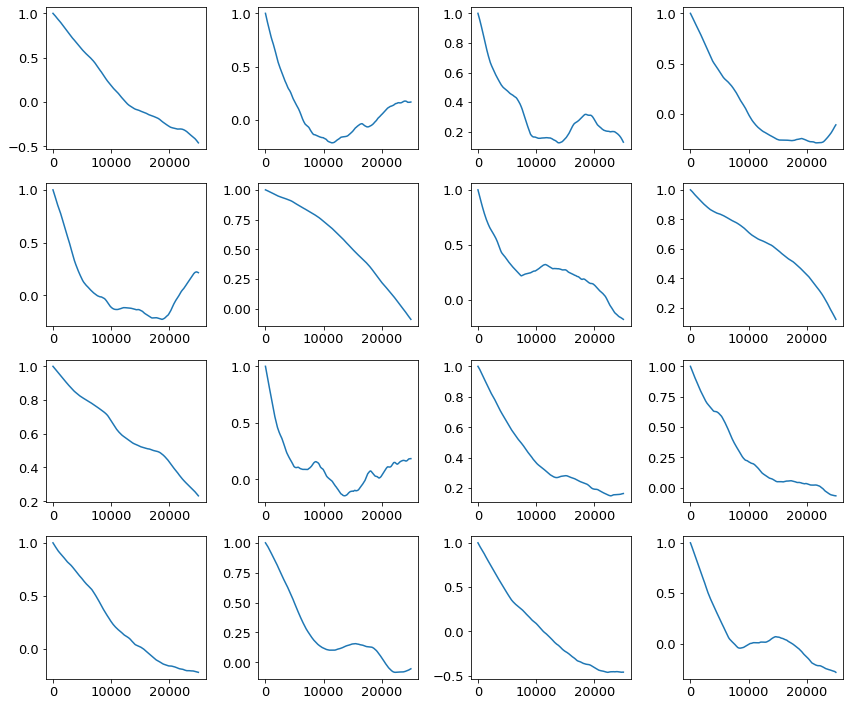

In [14]:
# plot auto-correlation

fig, axs = plt.subplots(4, 4, figsize=(12, 10))
axs = axs.flatten()
max_lag = int(n_iter/4)
for k in range(len(axs)):
    i = np.random.randint(0, parameters.shape[1])
    auto_cor = []
    mean = np.mean(parameters[:, i])
    var = np.var(parameters[:, i])
    for lag in range(1, max_lag):
        param = parameters[lag:, i]
        param_lagged = parameters[:-lag, i]
        auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
    axs[k].plot(np.arange(1, max_lag), auto_cor)
plt.tight_layout()
plt.savefig(fig_dir / "parameters.png")
plt.show()

We conduct the same operation with $\log(\gamma)$ and $\log(\lambda)$. These are more prone to show high-correlation, especially $\log(\lambda)$, as explained earlier. If that's the case, I would suggest to slightly increase `epsilon` as long as the acceptance rate doesn't drop, and then increase `L`.

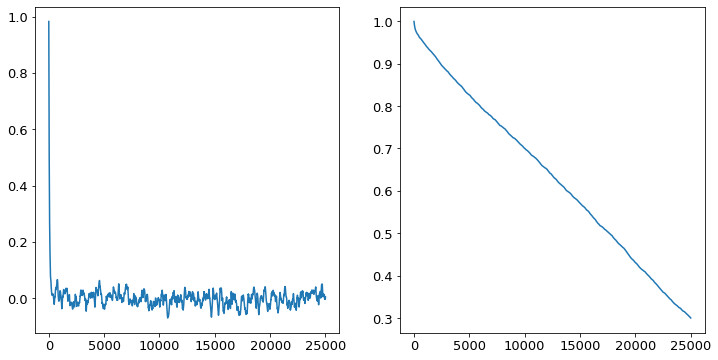

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.flatten()

mean = np.mean(log_gamma)
var = np.var(log_gamma)
auto_cor = []
for lag in range(1, max_lag):
    param = log_gamma[lag:]
    param_lagged = log_gamma[:-lag]
    auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
axs[0].plot(np.arange(1, max_lag), auto_cor)

mean = np.mean(log_lambda)
var = np.var(log_lambda)
auto_cor = []
for lag in range(1, max_lag):
    param = log_lambda[lag:]
    param_lagged = log_lambda[:-lag]
    auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
axs[1].plot(np.arange(1, max_lag), auto_cor)
plt.savefig(fig_dir / "gamma_lambda.png")
plt.show()

We can also have a look at the parameter spread and correlation. It should be close to a centered gaussian in most cases.

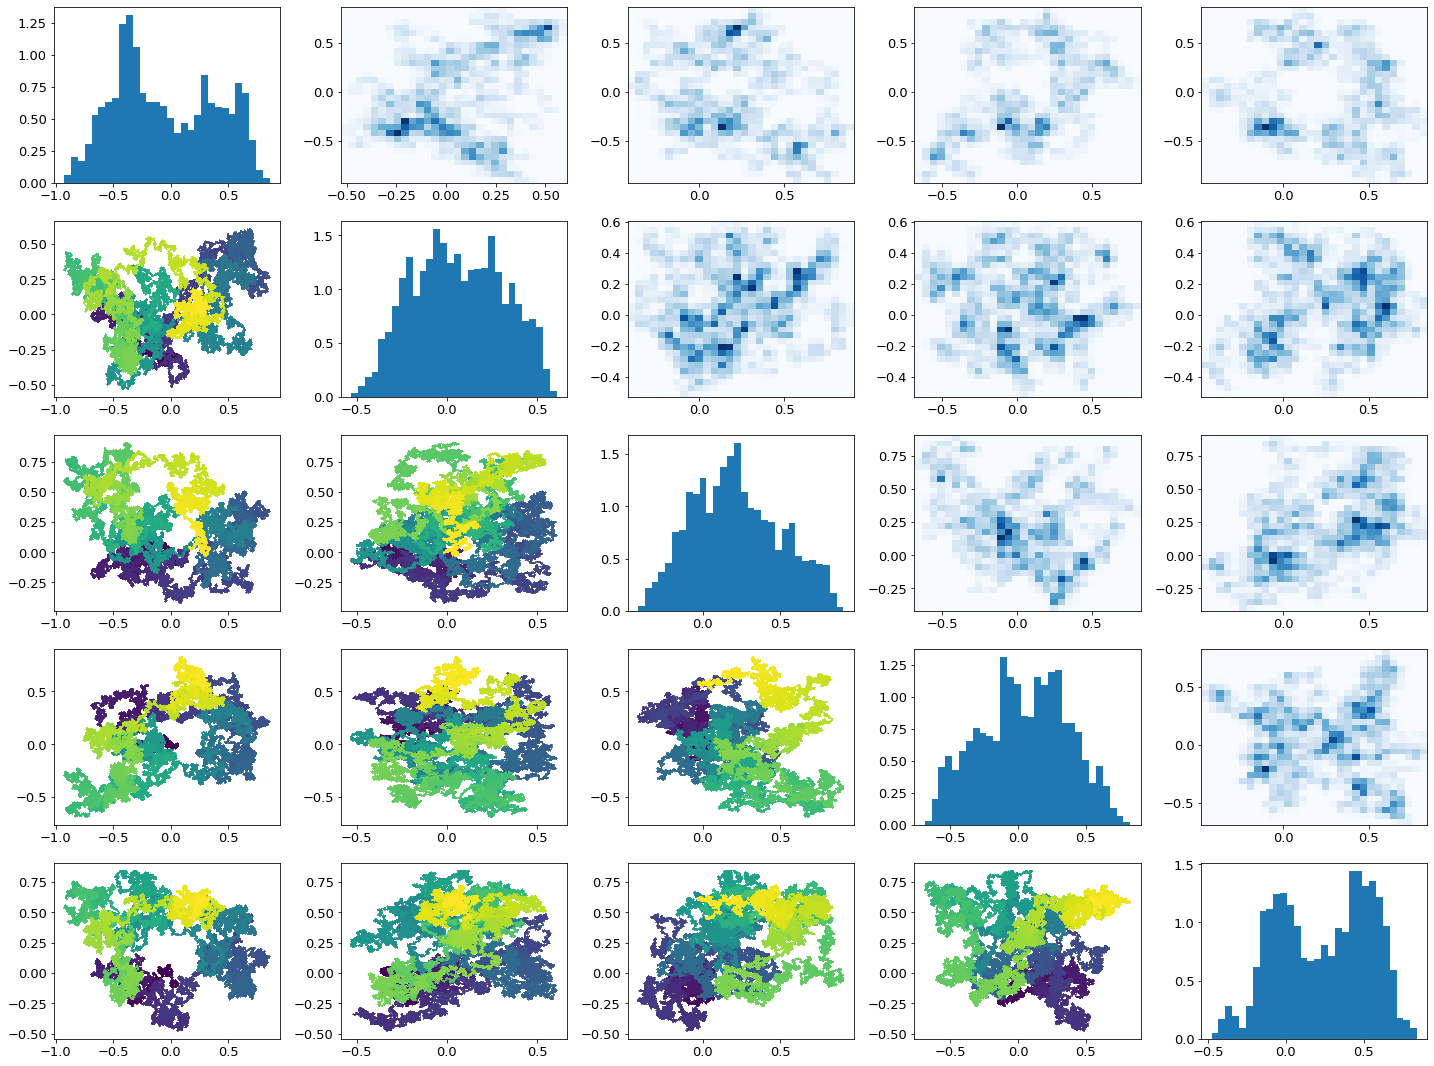

In [16]:
# plot parameters spread
fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(axs.shape[0]):
    axs[i, i].hist(parameters[:, i], bins=30, density=True)
    for j in range(i):
        axs[i, j].scatter(parameters[:, j], parameters[:, i], s=1, marker="+", c=np.arange(parameters.shape[0]))
    for j in range(i + 1, axs.shape[0]):
        axs[i, j].hist2d(parameters[:, j], parameters[:, i], bins=30, cmap="Blues")
plt.tight_layout()
plt.savefig(fig_dir / "spread.png")
plt.show()

## Predictions

Let's now have a look at the computed predictions and uncertainties.

In [17]:
# Logging predictions in their respective dataframes
val['NEE_MAP'] = NEE_val_MAP
val['Reco_MAP'] = Reco_val_MAP
val['GPP_MAP'] = GPP_val_MAP
test['NEE_MAP'] = NEE_test_MAP
test['Reco_MAP'] = Reco_test_MAP
test['GPP_MAP'] = GPP_test_MAP
train['NEE_MAP'] = NEE_train_MAP
train['Reco_MAP'] = Reco_train_MAP
train['GPP_MAP'] = GPP_train_MAP

val['NEE_mean'] = mu_NEE_pred_val
val['Reco_mean'] = mu_Reco_pred_val
val['GPP_mean'] = mu_GPP_pred_val
test['NEE_mean'] = mu_NEE_pred_test
test['Reco_mean'] = mu_Reco_pred_test
test['GPP_mean'] = mu_GPP_pred_test
train['NEE_mean'] = mu_NEE_pred_train
train['Reco_mean'] = mu_Reco_pred_train
train['GPP_mean'] = mu_GPP_pred_train

val['NEE_sigma'] = sigma_NEE_pred_val
val['Reco_sigma'] = sigma_Reco_pred_val
val['GPP_sigma'] = sigma_GPP_pred_val
test['NEE_sigma'] = sigma_NEE_pred_test
test['Reco_sigma'] = sigma_Reco_pred_test
test['GPP_sigma'] = sigma_GPP_pred_test
train['NEE_sigma'] = sigma_NEE_pred_train
train['Reco_sigma'] = sigma_Reco_pred_train
train['GPP_sigma'] = sigma_GPP_pred_train

train_day = train.loc[train.APAR_label == 1,]
train_night = train.loc[train.APAR_label == 0,]
test_day = test.loc[test.APAR_label == 1,]
test_night = test.loc[test.APAR_label == 0,]
val_day = val.loc[val.APAR_label == 1,]
val_night = val.loc[val.APAR_label == 0,]

Usually the respiration gets the worst performance. I tried different model architectures and this seems to be the "best" one (even though it's far from optimal). I think 2 effects are conjugated here:

- The respiration has a lower amplitude than the GPP, thus the model primary focuses on the GPP as it's responsible for a larger part of the loss;
- The Laplace prior for the model parameters is enforcing too much sparsity, which harms the performances;

On the left, the entire training and testing sets are shown (it's not the best as they are quite large, I'll work on that). On the right the MAP estimates are plotted against the observed values.

The MAP estimate seems to capture the global trend, but is quite inaccurate. The uncertainty is so high that the predictions are almost unusable.

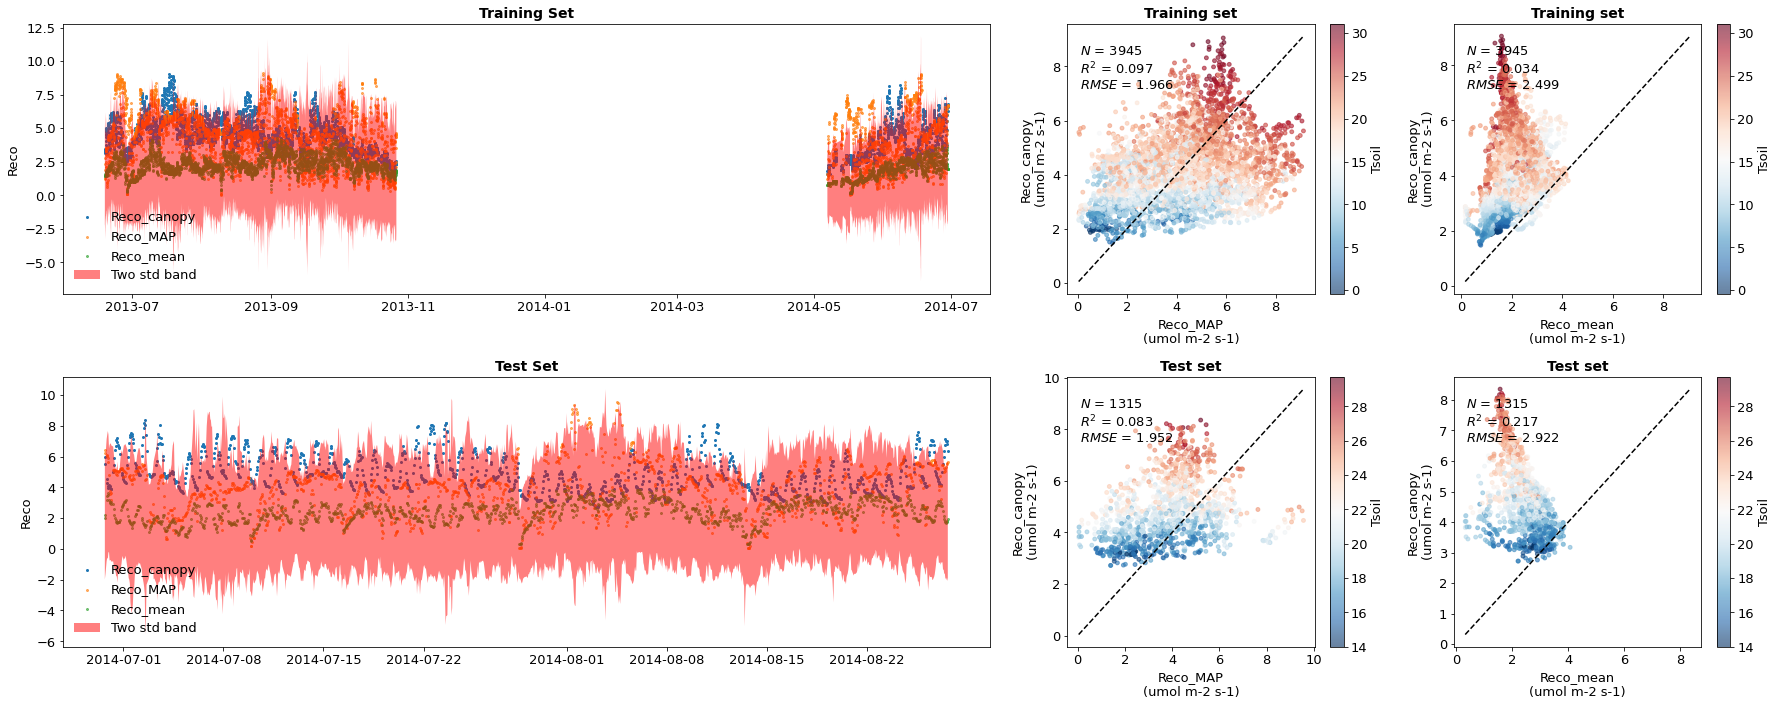

Ratio of training observations outside the 2σ band: 1.21e-01
Ratio of testing observations outside the 2σ band: 2.37e-01


In [18]:
fig, ax = quad_viz(train, test, "Reco", colors="Tsoil", unit="(umol m-2 s-1)", filename= fig_dir / "reco.png")
print("Ratio of training observations outside the 2σ band: {r:.2e}".format(r=count_out_distribution(train, "Reco") / train.shape[0]))
print("Ratio of testing observations outside the 2σ band: {r:.2e}".format(r=count_out_distribution(test, "Reco") / test.shape[0]))

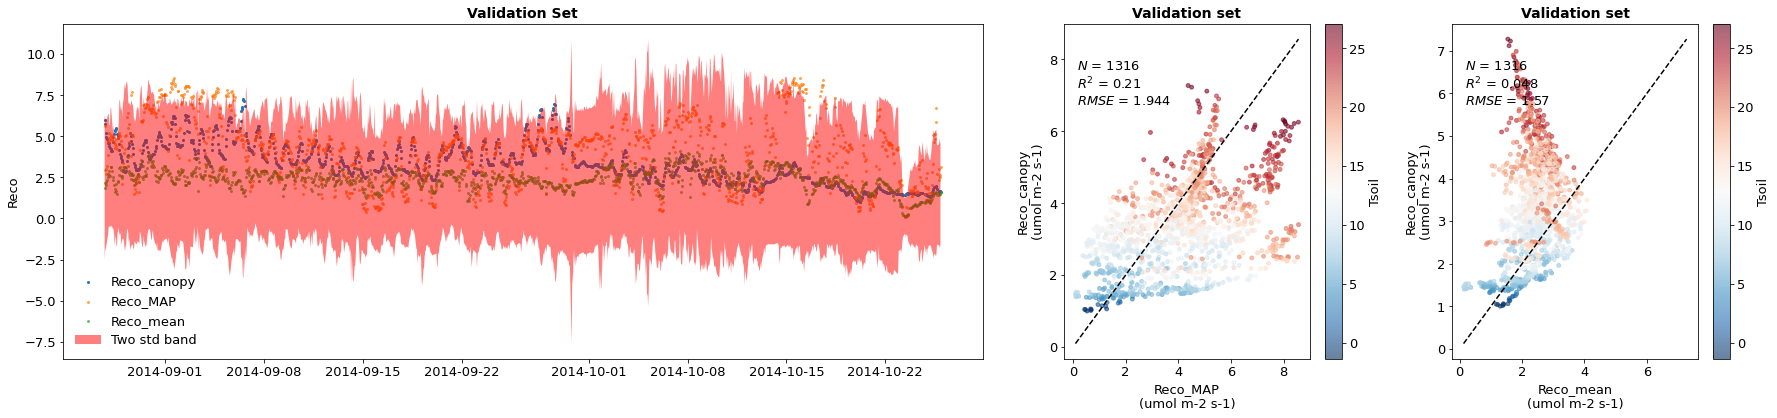

In [19]:
fig, ax = dual_viz_val(val, "Reco", colors="Tsoil", unit="(umol m-2 s-1)", filename= fig_dir / "reco_val.png")

Results are much better for the GPP part. Again, the data sets are too large to have a nice time-series plot. But here, the MAP estimates are much more accurate, with a high $R^2$, and when zooming on the test set, the uncertainty seem to be completely reasonable.

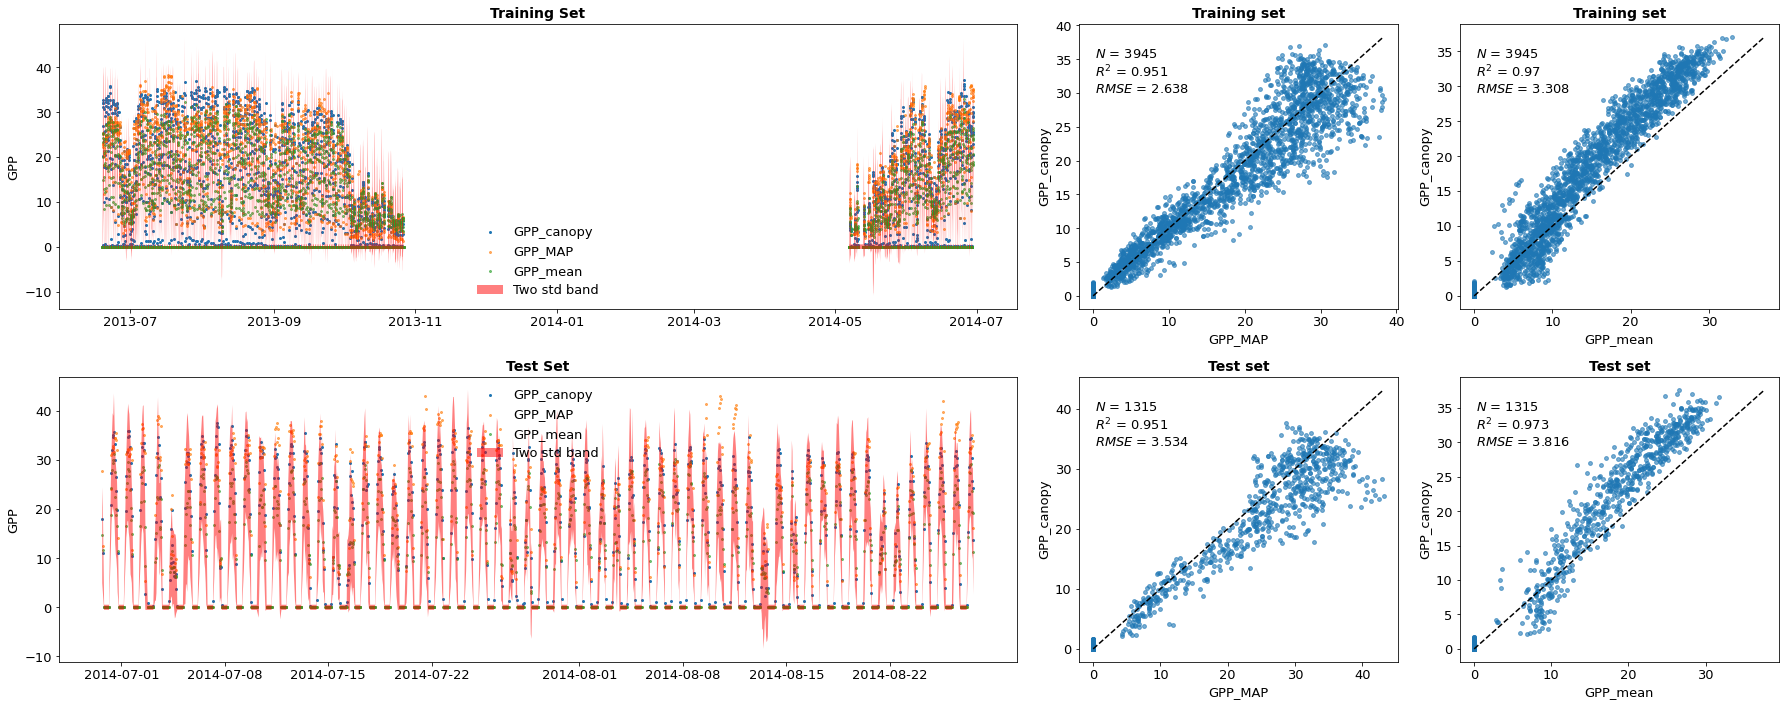

Ratio of training observations outside the 2σ band: 2.94e-02
Ratio of testing observations outside the 2σ band: 4.18e-02


In [20]:
fig, ax = quad_viz(train, test, "GPP", filename=fig_dir / "gpp.png")
print("Ratio of training observations outside the 2σ band: {r:.2e}".format(r=count_out_distribution(train, "GPP") / train.shape[0]))
print("Ratio of testing observations outside the 2σ band: {r:.2e}".format(r=count_out_distribution(test, "GPP") / test.shape[0]))

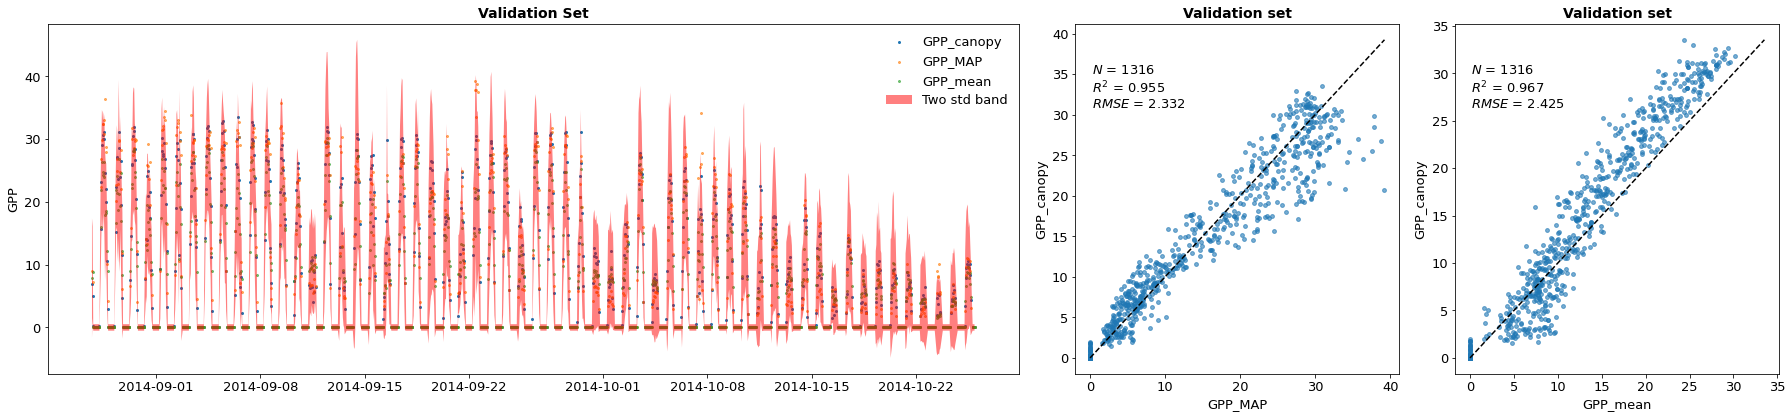

In [21]:
fig, ax = dual_viz_val(val, "GPP", filename=fig_dir / "gpp_val.png")

For control, here is the NEE trajectory. The performances are good overall, despite the poor results for Reco, which seems to confirm that the modeling choices are giving too much weight to GPP.

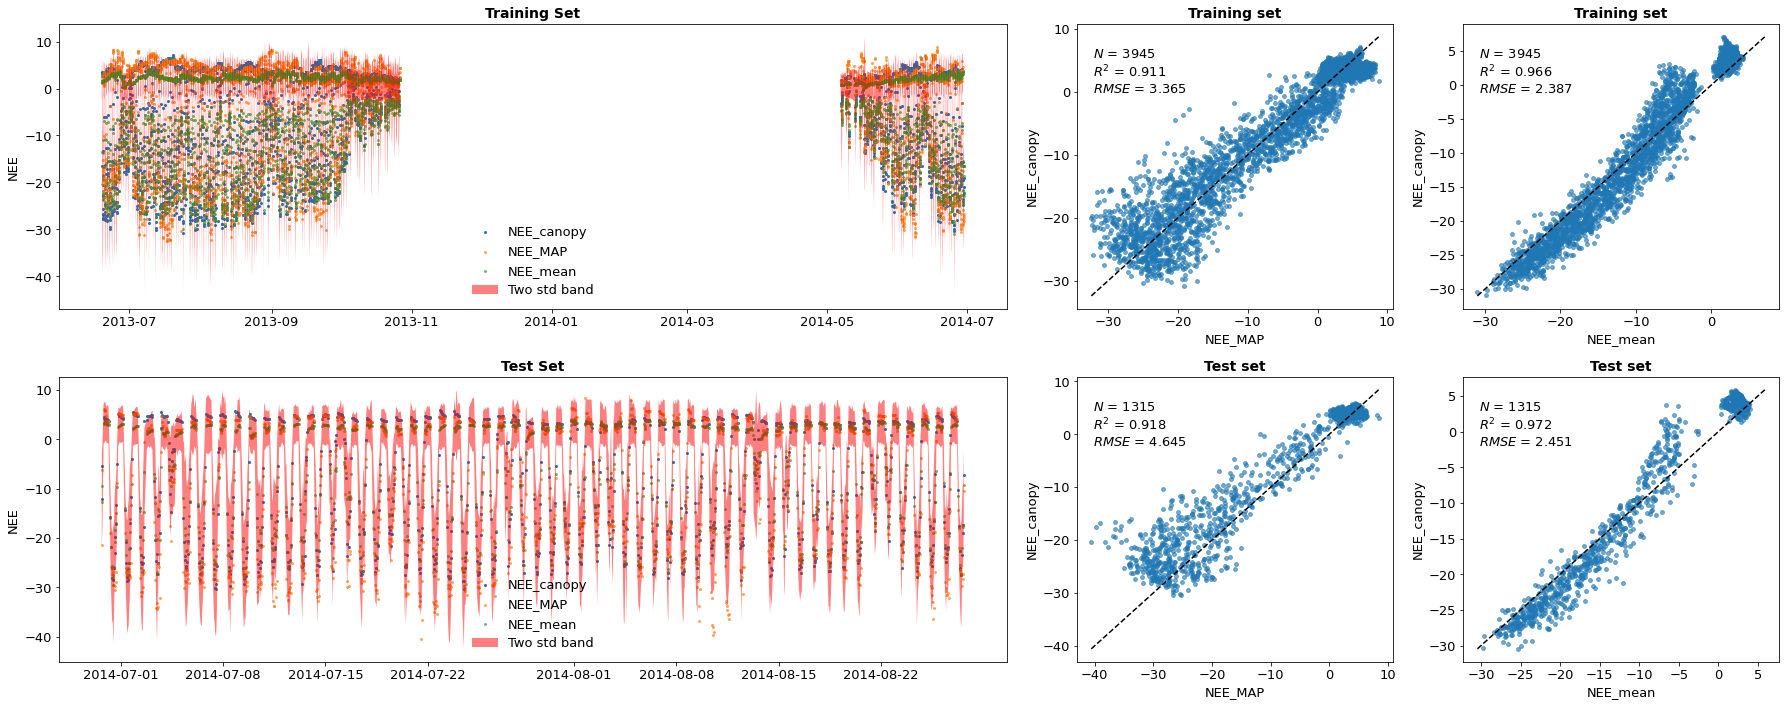

Ratio of training observations outside the 2σ band: 1.72e-02
Ratio of testing observations outside the 2σ band: 2.66e-02


In [22]:
fig, ax = quad_viz(train, test, "NEE", filename=fig_dir / "nee.png")
print("Ratio of training observations outside the 2σ band: {r:.2e}".format(r=count_out_distribution(train, "NEE") / train.shape[0]))
print("Ratio of testing observations outside the 2σ band: {r:.2e}".format(r=count_out_distribution(test, "NEE") / test.shape[0]))

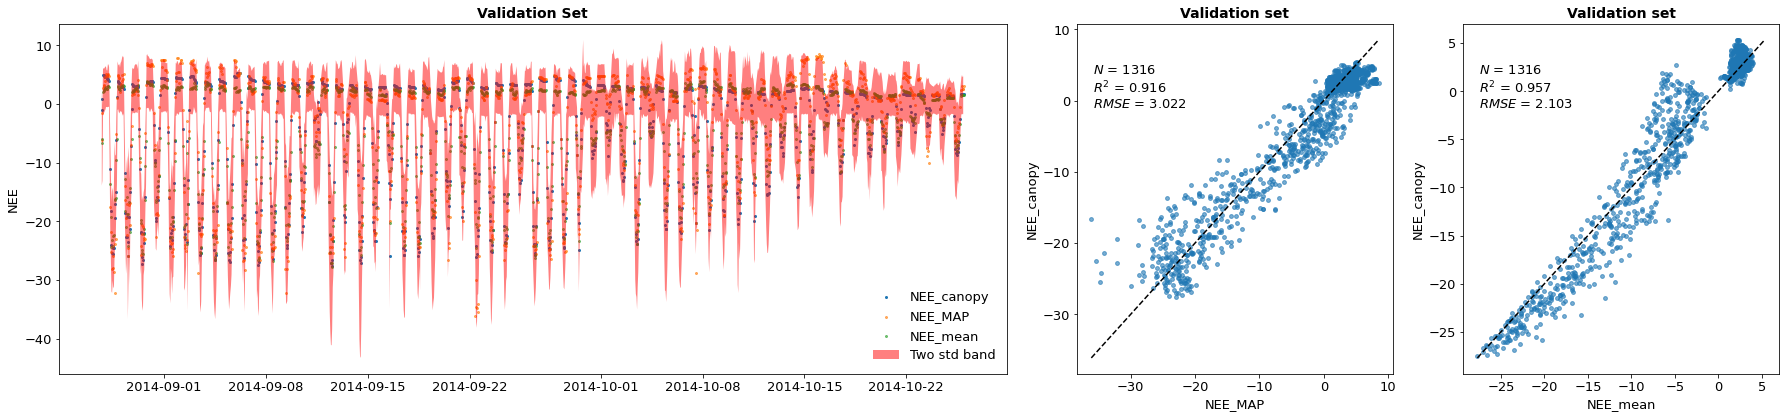

In [23]:
fig, ax = dual_viz_val(val, "NEE", filename=fig_dir / "nee_val.png")

## Deterministic tests

At first, I thought that the Bayesian modeling was enforcing too much sparsity on the parameters. Thus, I tried to train a few NN models with different $L_1$ regularization. It is not as conclusive as I expected, but it's not enough to reject the hypothesis either.

Without any regularization, the predictions are much closer than our previous MAP estimate.

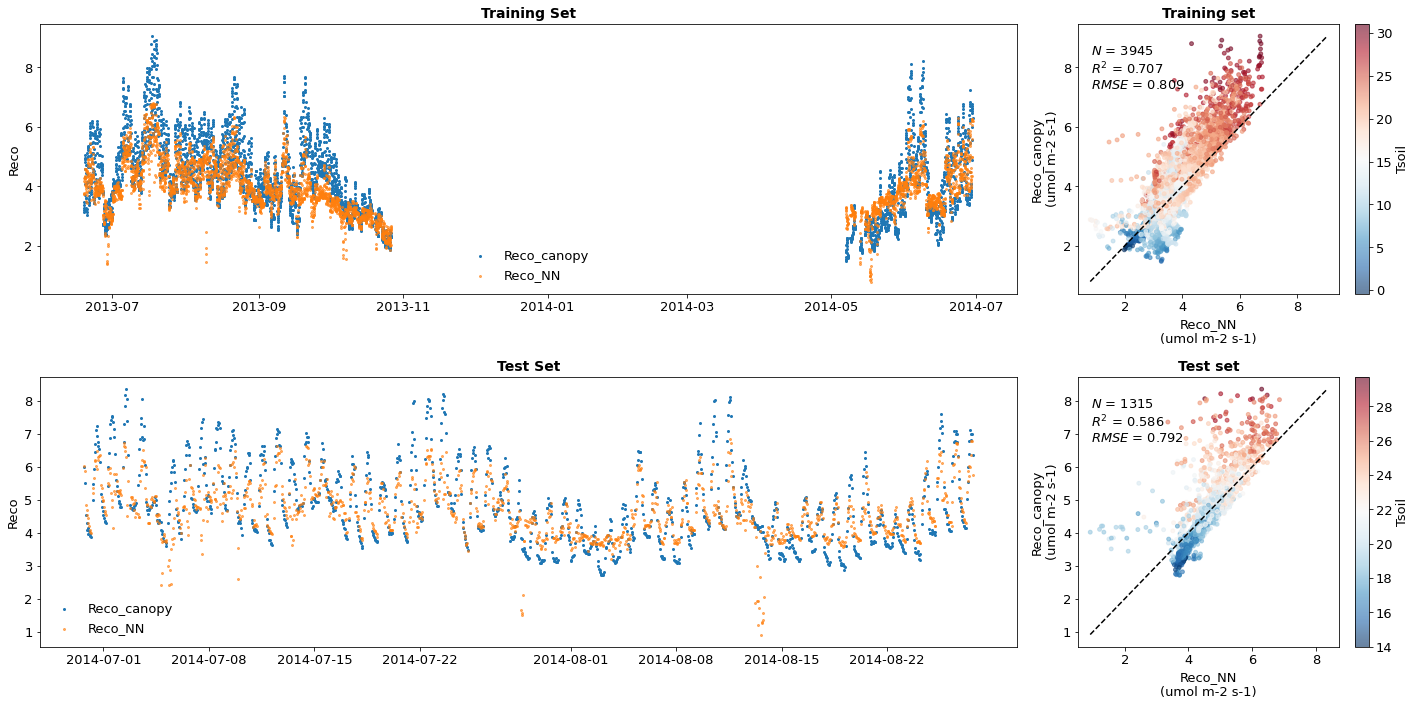

In [24]:
# GPP
APAR_input = Input(shape=(1,), dtype='float32', name='APAR_input')
EV_input1 = Input(shape=(EV1_train1.shape[1],), dtype='float32', name='EV_input1')
x = Dense(hidden_dim, activation="relu", name='hidden1_1')(EV_input1)
ln_GPP = Dense(1, activation="relu", name='ln_GPP')(x)
# GPP_1 = Lambda(lambda x: K.exp(x), name='GPP_1')(ln_GPP)
GPP = keras.layers.Multiply(name='GPP')([ln_GPP, APAR_input])

# Reco
EV_input2 = Input(shape=(EV2_train1.shape[1],), dtype='float32', name='EV_input2')
x = Dense(hidden_dim, activation="relu", name='hidden2_1')(EV_input2)
x = Dense(hidden_dim, activation="relu", name='hidden2_2')(x)
ln_Reco = Dense(1, activation=None, name='ln_Reco')(x)
Reco = Lambda(lambda x: K.exp(x), name='Reco')(ln_Reco)

NEE = keras.layers.Subtract(name='NEE')([Reco, GPP])

model_NEE = Model(inputs=[APAR_input, EV_input1, EV_input2], outputs=[NEE])
model_NEE.compile(
    optimizer=keras.optimizers.Adam(2e-3),
    loss=keras.losses.MeanSquaredError()
)
model_NEE.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             {'NEE': NEE_train1},
                             epochs=500,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)
NEE_train_NN, GPP_train_NN, Reco_train_NN = fluxes_SIF_predict_noSIF(model_NEE, label_train, EV1_train1, EV2_train1, NEE_max_abs)
NEE_test_NN, GPP_test_NN, Reco_test_NN = fluxes_SIF_predict_noSIF(model_NEE, label_test, EV1_test1, EV2_test1, NEE_max_abs)
test['NEE_NN'] = NEE_test_NN
test['Reco_NN'] = Reco_test_NN
test['GPP_NN'] = GPP_test_NN
train['NEE_NN'] = NEE_train_NN
train['Reco_NN'] = Reco_train_NN
train['GPP_NN'] = GPP_train_NN
fig, ax = quad_viz(train, test, "Reco", colors="Tsoil", unit="(umol m-2 s-1)", bayesian=False)
None

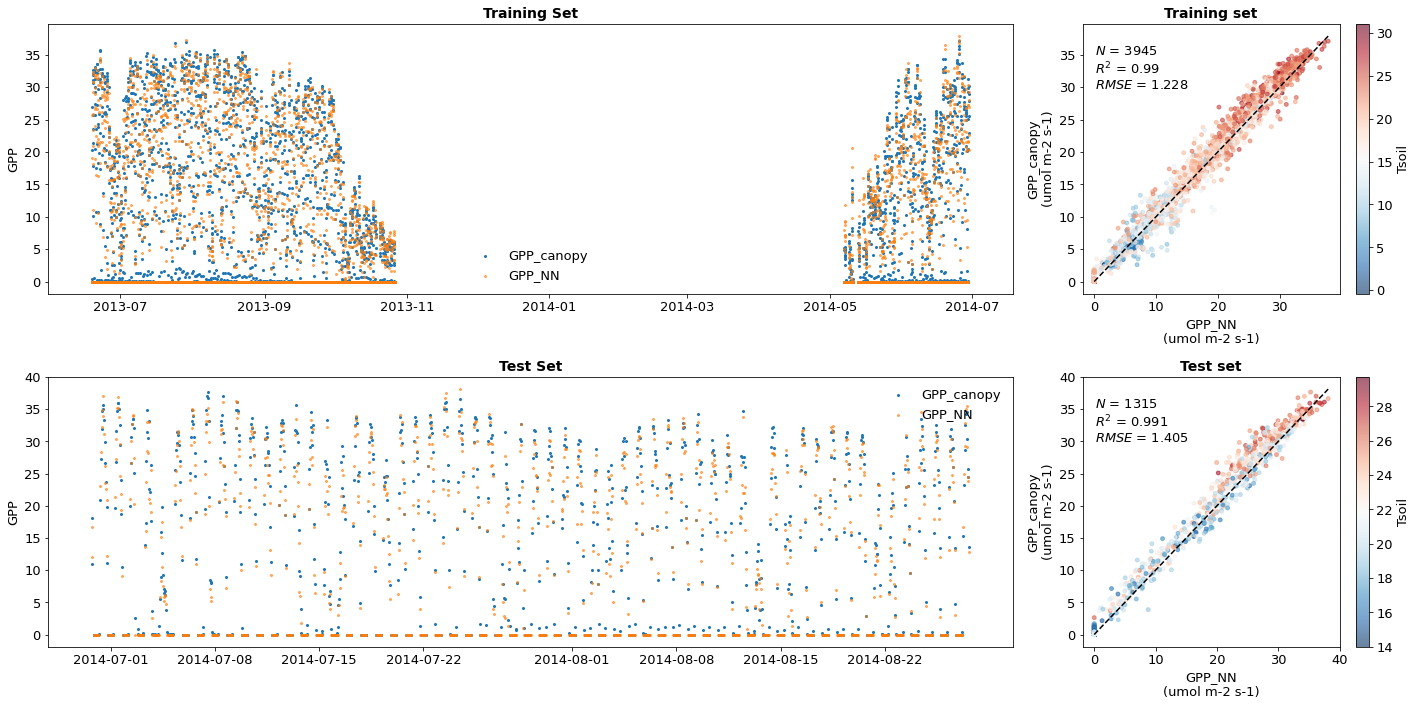

In [25]:
fig, ax = quad_viz(train, test, "GPP", colors="Tsoil", unit="(umol m-2 s-1)", bayesian=False)

In [26]:
label_train_night = tf.boolean_mask(label_train, label_train == 0)
EV1_train1_night = tf.boolean_mask(EV1_train1, label_train == 0)
EV2_train1_night = tf.boolean_mask(EV2_train1, label_train == 0)
NEE_train1_night = tf.boolean_mask(NEE_train1, label_train == 0)

# label_test_night = tf.boolean_mask(label_test, label_test == 0)
# EV1_test1_night = tf.boolean_mask(EV1_test1, label_test == 0)
# EV2_test1_night = tf.boolean_mask(EV2_test1, label_test == 0)
# NEE_test1_night = tf.boolean_mask(NEE_test1, label_test == 0)


# GPP
APAR_input = Input(shape=(1,), dtype='float32', name='APAR_input')
EV_input1 = Input(shape=(EV1_train1.shape[1],), dtype='float32', name='EV_input1')
x = Dense(hidden_dim, activation="relu", name='hidden1_1')(EV_input1)
base_GPP = Dense(1, activation="relu", name='base_GPP')(x)
GPP = keras.layers.Multiply(name='GPP')([base_GPP, APAR_input])

# Reco
EV_input2 = Input(shape=(EV2_train1.shape[1],), dtype='float32', name='EV_input2')
x = Dense(hidden_dim, activation="relu", name='hidden2_1')(EV_input2)
x = Dense(hidden_dim, activation="relu", name='hidden2_2')(x)
ln_Reco = Dense(1, activation=None, name='ln_Reco')(x)
Reco = Lambda(lambda x: K.exp(x), name='Reco')(ln_Reco)

NEE = keras.layers.Subtract(name='NEE')([Reco, GPP])

model_NEE = Model(inputs=[APAR_input, EV_input1, EV_input2], outputs=[NEE])
model_NEE.compile(
    optimizer=keras.optimizers.Adam(2e-3),
    loss=keras.losses.MeanSquaredError()
)
model_NEE.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             {'NEE': NEE_train1},
                             epochs=500,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)
model_NEE.fit({'APAR_input': label_train_night, 'EV_input1': EV1_train1_night, 'EV_input2': EV2_train1_night},
                             {'NEE': NEE_train1_night},
                             epochs=20,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)

NEE_train_NN, GPP_train_NN, Reco_train_NN = fluxes_SIF_predict_noSIF(model_NEE, label_train, EV1_train1, EV2_train1, NEE_max_abs)
NEE_test_NN, GPP_test_NN, Reco_test_NN = fluxes_SIF_predict_noSIF(model_NEE, label_test, EV1_test1, EV2_test1, NEE_max_abs)
test['NEE_NN'] = NEE_test_NN
test['Reco_NN'] = Reco_test_NN
test['GPP_NN'] = GPP_test_NN
train['NEE_NN'] = NEE_train_NN
train['Reco_NN'] = Reco_train_NN
train['GPP_NN'] = GPP_train_NN
train_day = train.loc[train.APAR_label == 1,]
train_night = train.loc[train.APAR_label == 0,]
test_day = test.loc[test.APAR_label == 1,]
test_night = test.loc[test.APAR_label == 0,]

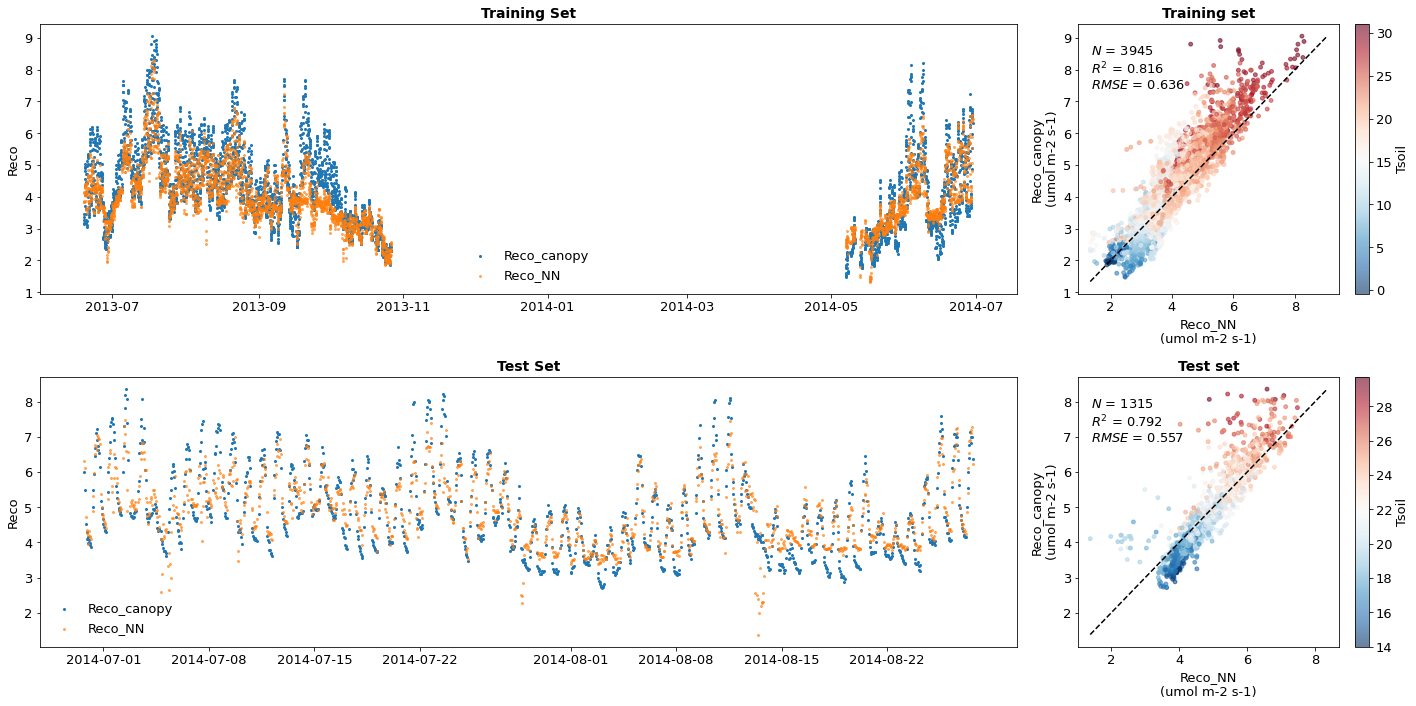

In [27]:
fig, ax = quad_viz(train, test, "Reco", colors="Tsoil", unit="(umol m-2 s-1)", bayesian=False)

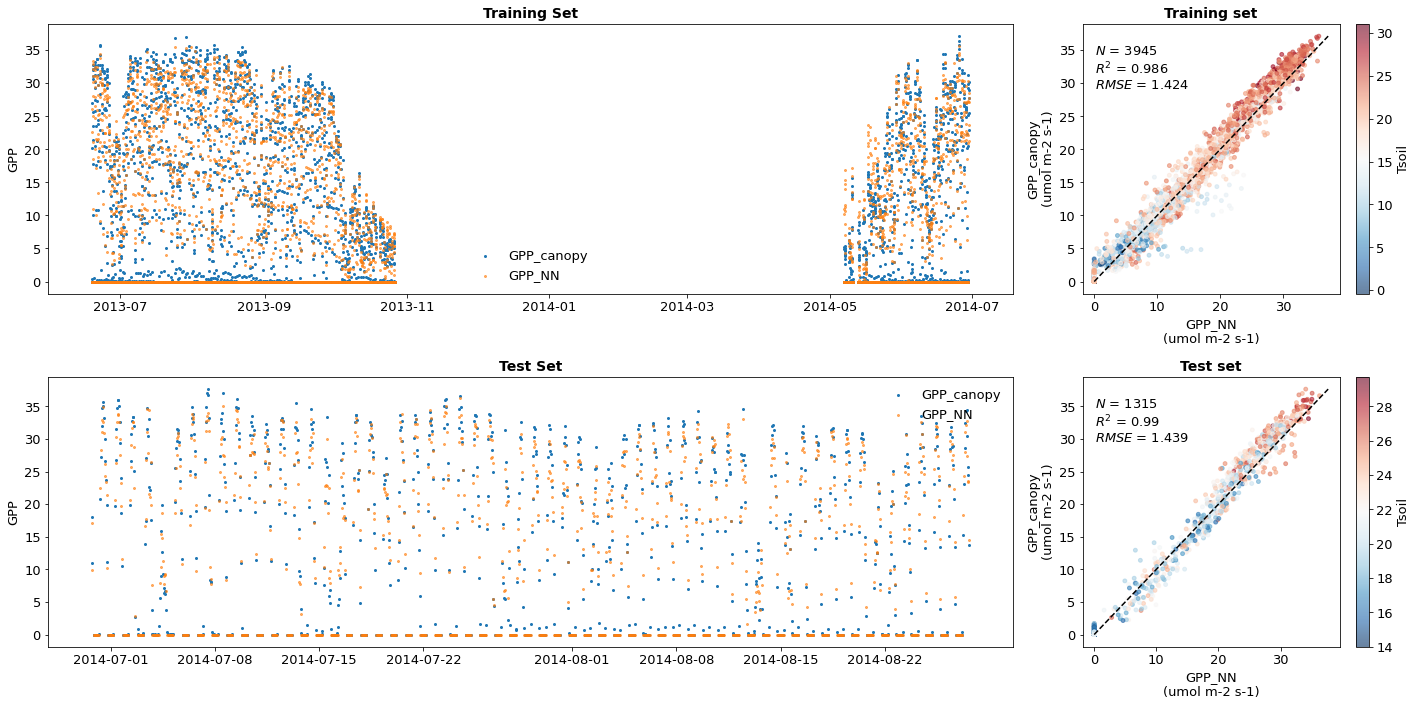

In [28]:
fig, ax = quad_viz(train, test, "GPP", colors="Tsoil", unit="(umol m-2 s-1)", bayesian=False)

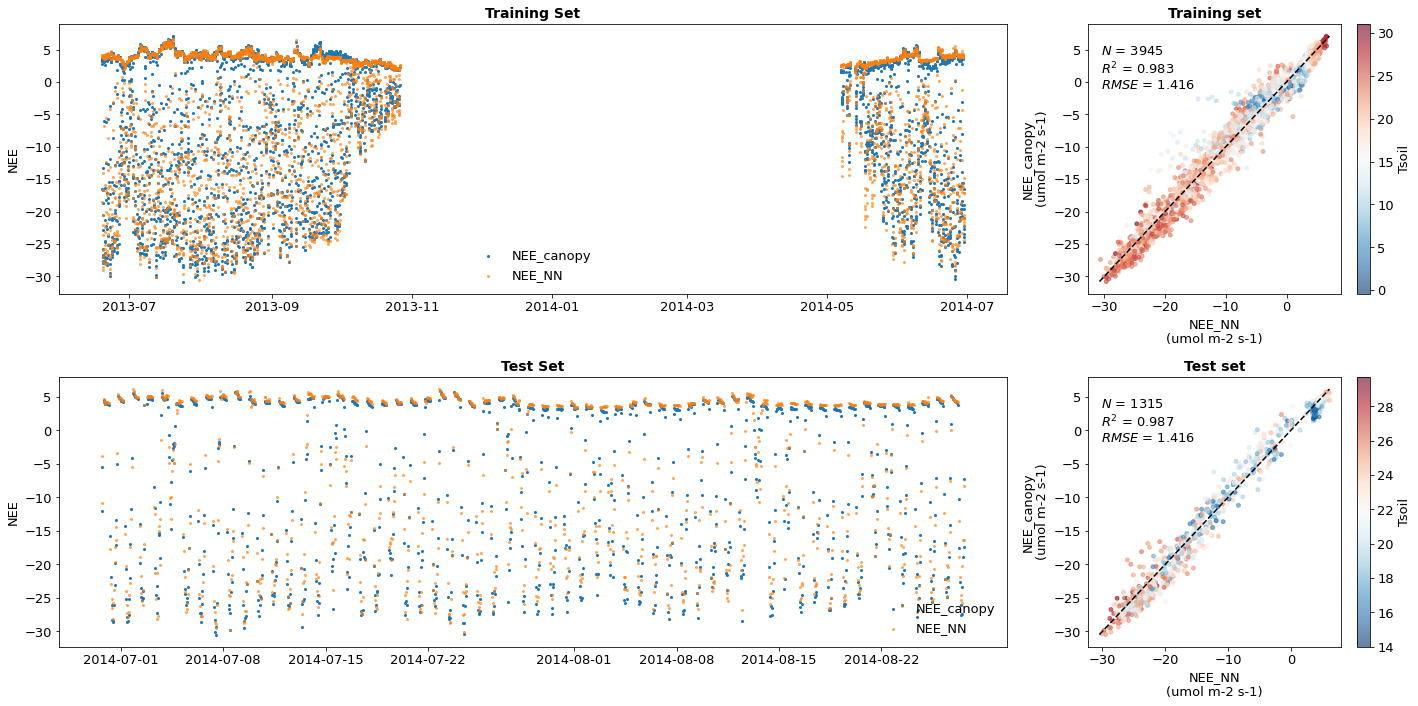

In [29]:
fig, ax = quad_viz(train, test, "NEE", colors="Tsoil", unit="(umol m-2 s-1)", bayesian=False)

Custom loss function that takes higher values at night?